# Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

There are three types of classification problems:

-   Binary classification: The output is one of two classes. For example, spam detection.
-   Multi-class classification: The output is one of more than two classes. For example, handwritten digit recognition.
-   Multi-label classification: The output is a list of classes. For example, tagging a movie with genres.

> The difference between multi-class and multi-label classification is that in multi-class classification, the classes are mutually exclusive, while in multi-label classification, the classes are not mutually exclusive.


## Make classification data and get it ready


In [248]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

X.shape, y.shape

((1000, 2), (1000,))

In [249]:
# Make DataFrame of circles
import pandas as pd

circles = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "label": y})
circles.head(10)

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [250]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

Text(0.5, 1.0, 'Circles in 2D')

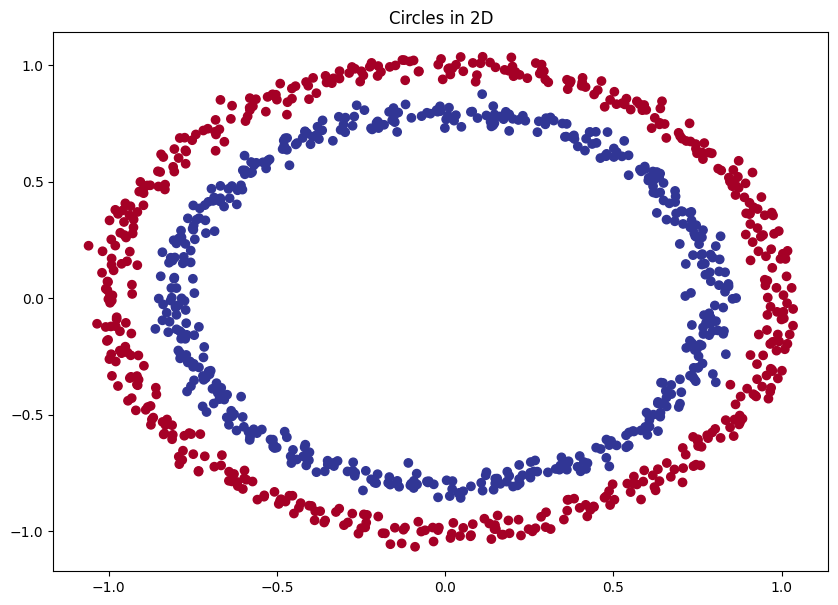

In [251]:
# Plot circles
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.title("Circles in 2D")

**Note**: The data is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizable enough to practice the fundamentals

In this circles dataset, we have two features, x1 and x2, and a target, y. The target is binary, meaning it has two classes: 0 and 1. Our goal is to predict the target based on the features.


### Check input and output shapes


In [252]:
X.shape, y.shape

((1000, 2), (1000,))

In [253]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

X_sample, y_sample, X_sample.shape, y_sample.shape

(array([0.75424625, 0.23148074]), np.int64(1), (2,), ())

### Turn data into tensors and create train and test splits


In [254]:
import torch

torch.__version__

'2.4.0.dev20240427'

In [255]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X.dtype, y.dtype

(torch.float32, torch.float32)

In [256]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## Build a classification model

The model classify blue and red dots. To do so, we want to:

1. Setup device agonistic code so our code will run on an accelerator if it's available.
2. Construct a model (by subclassing `torch.nn.Module`)
    1. Subclasses `torch.nn.Module`
    2. Create 2 `nn.Linear()` layers that are capable of handling
    3. Defines a `forward()` method that returns the output of the model after passing an input through the layers.
    4. Instantiates the model and sends it to the target device.
3. Define a loss function and an optimizer
4. Create a training and test loop


In [257]:
from torch import nn

# Device-agnostic code
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'mps'

In [258]:
from sklearn import datasets


# 1. Construct a model that subclasses the nn.Module class
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Define the 2 nn.Linear layers capable of handling the shapes of data
        self.fc1 = nn.Linear(in_features=2, out_features=5)  # out_features is arbitrary
        self.fc2 = nn.Linear(
            in_features=5, out_features=1
        )  # out_features is 1 because it's a binary classification problem (0 or 1) - same shape as y

        # self.two_linear_layers = nn.Sequential(self.fc1, self.fc2)

    # 3. Define the forward method
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer2(self.layer1(x))  # x -> layer1 -> layer2
        # return self.two_linear_layers(x)


# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

In [259]:
next(model_0.parameters()).device

device(type='mps', index=0)

In [260]:
# Use nn.Sequential to chain layers together
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [261]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='mps:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='mps:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='mps:0')),
             ('1.bias', tensor([-0.1213], device='mps:0'))])

In [262]:
# Make predictions with the model
with torch.inference_mode():
    y_untrained_preds = model_0(X_test.to(device))
    print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
    print(
        f"Length of predictions: {len(y_untrained_preds)}, Shape: {y_untrained_preds.shape}"
    )
    print(f"\nFirst 10 predictions: \n{y_untrained_preds[:10]}")
    print(f"\nFirst 10 actual labels: \n{y_test[:10]}")

Length of test samples: 200, Shape: torch.Size([200, 2])
Length of predictions: 200, Shape: torch.Size([200, 1])

First 10 predictions: 
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='mps:0')

First 10 actual labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Setup loss function and optimizer

For regression, we might want to use MAE or MSE (mean absolute error or mean squared error) as the loss function.

For classification, we might w ant to use binary cross-entropy or categorical cross-entropy loss (cross-entropy loss).

For optimizer, two most common and useful optimizers are Adam and SGD (stochastic gradient descent).

-   Loss function: `torch.nn.BCEWithLogitsLoss()`
-   Optimizer: `torch.optim.SGD()`


In [263]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = (
    nn.BCEWithLogitsLoss()
)  # BCEWithLogitsLoss = sigmoid activation + binary cross-entropy loss

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [264]:
# Calculate accuracy - out of 100 samples, what percentage of the model's predictions match the actual labels
def accuracy_fn(y_true, y_pred):
    return torch.sum(y_true == y_pred).item() * 100 / len(y_true)

## Train the model

Training loop steps:

1. Forward pass: Compute the predicted y by passing x to the model.
2. Compute the loss.
3. Optimizer zero grad.
4. Backward pass: Compute gradient of the loss with respect to model parameters.
5. Update the parameters using the gradients.


### Going from raw logits -> prediction probabilities -> prediction labels

The model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them through activation functions like `torch.sigmoid()` for binary classification or `torch.softmax()` for multi-class classification.

Then we can convert these **prediction probabilities** into **prediction labels** by rounding them to the nearest integer or taking the `argmax()` of the probabilities.


In [265]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='mps:0')

In [266]:
# Use the sigmoid activation function to turn logits into prediction probabilities
import torch.nn.functional as F

y_pred_probs = F.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='mps:0')

For the prediction probability values, we need to perform a range-style rounding to get the prediction labels.

-   `y_pred_probs` >= 0.5, `y=` (class 1)
-   `y_pred_probs` < 0.5, `y=` (class 0)


In [267]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(F.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.allclose(y_preds, y_pred_labels))

# Get rid of the extra dimension
y_preds.squeeze()

True


tensor([0., 0., 1., 0., 1.], device='mps:0')

In [268]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### Build a training and test loop


In [269]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    # Training phase
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(
        F.sigmoid(y_logits)
    )  # Turn logtis -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(F.sigmoid(y_logits), y_train) # nn.BCELoss() expects probabilities (not logits)
    loss = loss_fn(
        y_logits, y_train
    )  # nn.BCEWithLogitsLoss() expects logits (not probabilities)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero_grad
    optimizer.zero_grad()

    # 4. Backward pass (backpropagation)
    loss.backward()

    # 5. Step optimizer (gradient descent)
    optimizer.step()

    # Testing phase
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        y_test_logits = model_0(X_test).squeeze()
        y_test_pred = torch.round(F.sigmoid(y_test_logits))
        # 2. Calculate test loss/accuracy
        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_pred)

    # Print the metrics
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 0.69796 | Acc: 51.88% | Test loss: 0.69440 | Test acc: 58.00%
Epoch: 10 | Loss: 0.69590 | Acc: 51.25% | Test loss: 0.69305 | Test acc: 53.00%
Epoch: 20 | Loss: 0.69490 | Acc: 51.62% | Test loss: 0.69254 | Test acc: 49.50%
Epoch: 30 | Loss: 0.69435 | Acc: 51.12% | Test loss: 0.69236 | Test acc: 49.50%
Epoch: 40 | Loss: 0.69401 | Acc: 50.88% | Test loss: 0.69232 | Test acc: 51.00%
Epoch: 50 | Loss: 0.69378 | Acc: 50.25% | Test loss: 0.69234 | Test acc: 50.00%
Epoch: 60 | Loss: 0.69362 | Acc: 50.00% | Test loss: 0.69239 | Test acc: 51.50%
Epoch: 70 | Loss: 0.69351 | Acc: 50.25% | Test loss: 0.69246 | Test acc: 51.00%
Epoch: 80 | Loss: 0.69342 | Acc: 49.88% | Test loss: 0.69254 | Test acc: 50.00%
Epoch: 90 | Loss: 0.69336 | Acc: 49.88% | Test loss: 0.69262 | Test acc: 53.00%


## Make predictions and evaluate the model

From the metrics, it looks like model isn't learning anything. Below is the visualization of the model's predictions.


In [270]:
import requests
from pathlib import Path


# Download the helper function
def download_file(url: str, save_as: Path = None):
    if not save_as:
        save_as = Path(url.split("/")[-1])
    response = requests.get(url)
    with open(save_as, "wb") as f:
        f.write(response.content)
    return save_as


download_file(
    url="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py",
    save_as="helper_functions.py",
)

from helper_functions import plot_decision_boundary, plot_predictions

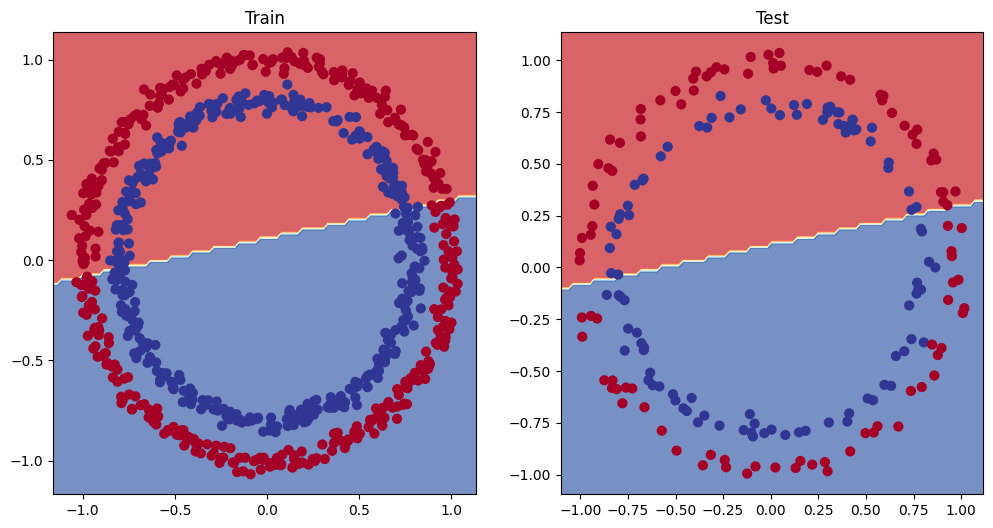

In [271]:
# Plot the decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_0, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_0, X=X_test, y=y_test)

## Improve the model (From a model perspective)

-   Add more layers - The more layers, the more complex patterns the model can learn.
-   Increase the number of hidden units - The more hidden units, the more complex patterns the model can learn (go from 5 to 10).
-   Train for longer - Increase the number of epochs (leave the learning rate the same for now).
-   Change the activation functions
-   Change the learning rate
-   Change the loss function

Options deal directly with the **model architecture** and **hyperparameters** (all values we can change) rather than the data -> model-centric improvements.

> **parameters** vs **hyperparameters**: parameters are learned from data, hyperparameters are set by the developer. For example, the weights in a neural network are parameters, the learning rate is a hyperparameter.

We will implement the following changes:

-   Adding more hidden units: 5 -> 10
-   Increasing the number of layers: 2-> 3
-   Increasing the number of epochs: 100 -> 1000

> Experiment tracking: Keep track of the experiments you've run so you can see how they've gone. In the real world, you'll want to change one thing at a time and see the effect it has. In this case, we'll change multiple things at once.


In [272]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc3(
            self.fc2(self.fc1(x))
        )  # this way leverages speed ups where possible behind the scenes


model_1 = CircleModelV2().to(device)
model_1

CircleModelV2(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [273]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [274]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.mps.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(
        torch.sigmoid(y_logits)
    )  # logits -> pred probabilities -> prediction labels

    # 2. Calculate the loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


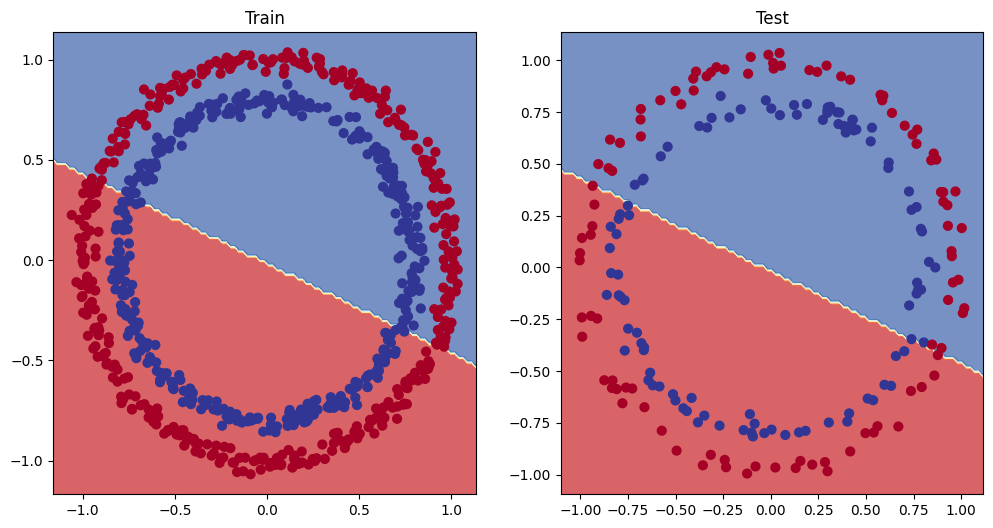

In [275]:
# Plot the decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_1, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_1, X=X_test, y=y_test)

### Prepare data to see if the model can fit a straight line

One way to troubleshoot to a larger model is to see if the model can fit a simple straight line. If it can't, it's likely the model isn't learning (smaller problem).


In [276]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.2
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

X_regression[:5], y_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.2000],
         [0.2070],
         [0.2140],
         [0.2210],
         [0.2280]]))

In [277]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = (
    X_regression[:train_split],
    y_regression[:train_split],
)
X_test_regression, y_test_regression = (
    X_regression[train_split:],
    y_regression[train_split:],
)

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(
    y_test_regression
)

(80, 20, 80, 20)

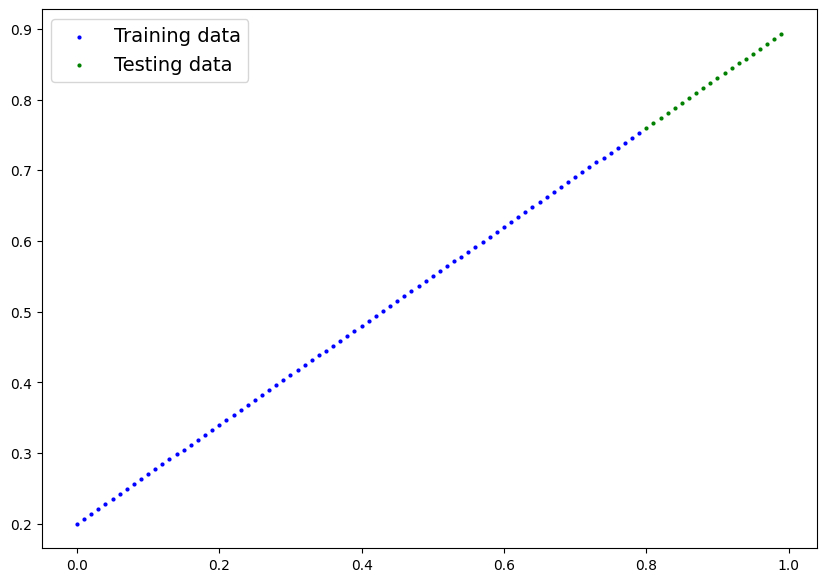

In [278]:
plot_predictions(
    X_train_regression, y_train_regression, X_test_regression, y_test_regression
)

In [279]:
X_train_regression[:5], y_train_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.2000],
         [0.2070],
         [0.2140],
         [0.2210],
         [0.2280]]))

### Adjusting `model_1` to fit a straight line


In [280]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [281]:
# Loss and optimizer
loss_fn = nn.L1Loss()  # MAE loss with regression data
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [282]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(
    device
), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(
    device
), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.65986 | Test loss: 0.81103
Epoch: 100 | Loss: 0.00752 | Test loss: 0.04420
Epoch: 200 | Loss: 0.01059 | Test loss: 0.04491
Epoch: 300 | Loss: 0.01436 | Test loss: 0.04453
Epoch: 400 | Loss: 0.01411 | Test loss: 0.04383
Epoch: 500 | Loss: 0.01399 | Test loss: 0.04269
Epoch: 600 | Loss: 0.01350 | Test loss: 0.04112
Epoch: 700 | Loss: 0.01275 | Test loss: 0.03910
Epoch: 800 | Loss: 0.01323 | Test loss: 0.03976
Epoch: 900 | Loss: 0.01247 | Test loss: 0.03872


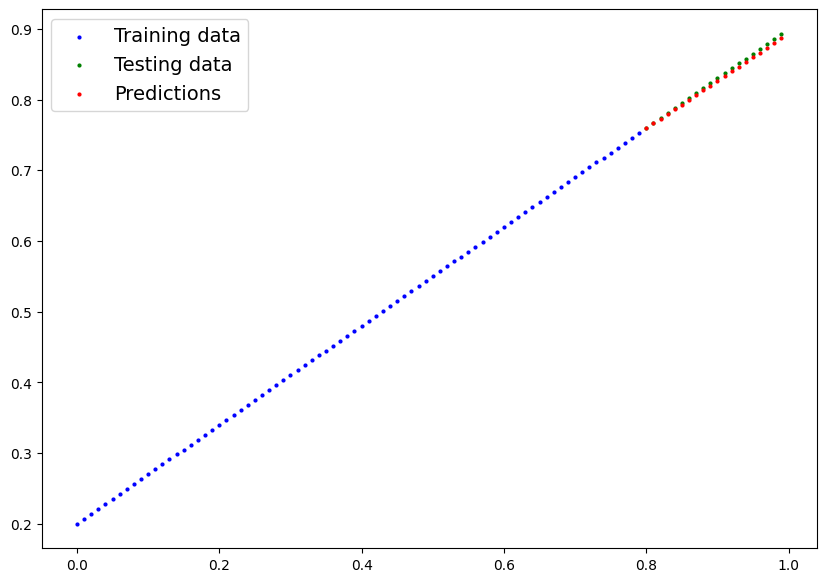

In [283]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(
    train_data=X_train_regression.cpu(),
    train_labels=y_train_regression.cpu(),
    test_data=X_test_regression.cpu(),
    test_labels=y_test_regression.cpu(),
    predictions=y_preds.cpu(),
)

## Non-linearity

"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?


### Recreating non-linear data (red and blue circles)


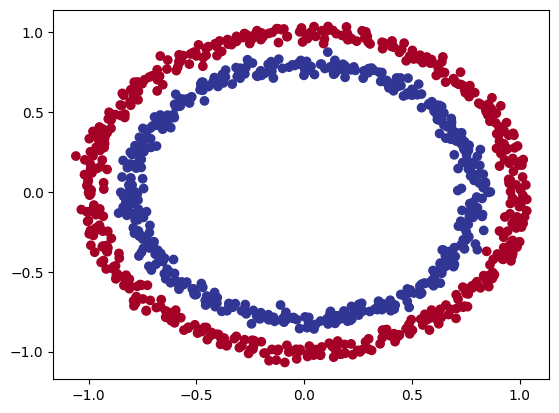

In [284]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [285]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### Build a model with non-linearity

-   Linear = straight line
-   Non-linear = not a straight line

Artificial neural networks are combinations of linear and non-linear functions. The linear functions are the `nn.Linear()` layers and the non-linear functions are the activation functions.


In [286]:
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc3(self.relu(self.fc2(self.relu(self.fc1(x)))))


model_3 = CircleModelV3().to(device)
model_3

CircleModelV3(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [287]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.01)

## Training model with non-linearity


In [288]:
# Training loop
torch.manual_seed(42)
torch.mps.manual_seed(42)

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Set the number of epochs
epochs = 1000

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test loss: 0.69203, Test acc: 55.50%
Epoch: 100 | Loss: 0.17334, Acc: 99.62% | Test loss: 0.20684, Test acc: 99.00%
Epoch: 200 | Loss: 0.01503, Acc: 100.00% | Test loss: 0.02743, Test acc: 100.00%
Epoch: 300 | Loss: 0.00581, Acc: 100.00% | Test loss: 0.01481, Test acc: 100.00%
Epoch: 400 | Loss: 0.00317, Acc: 100.00% | Test loss: 0.01065, Test acc: 100.00%
Epoch: 500 | Loss: 0.00200, Acc: 100.00% | Test loss: 0.00874, Test acc: 100.00%
Epoch: 600 | Loss: 0.00138, Acc: 100.00% | Test loss: 0.00754, Test acc: 100.00%
Epoch: 700 | Loss: 0.00101, Acc: 100.00% | Test loss: 0.00677, Test acc: 100.00%
Epoch: 800 | Loss: 0.00076, Acc: 100.00% | Test loss: 0.00622, Test acc: 100.00%
Epoch: 900 | Loss: 0.00060, Acc: 100.00% | Test loss: 0.00579, Test acc: 100.00%


### Evaluating the model trained with non-linearity activation functions


In [289]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'))

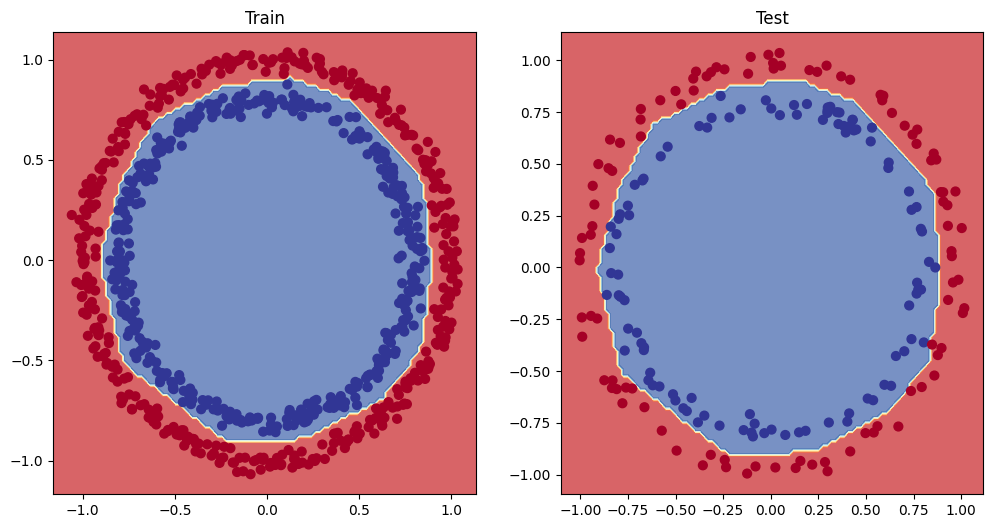

In [290]:
# Plot the decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_3, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_3, X=X_test, y=y_test)

## Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover pattern in data and it tries to figure out the patterns on its own.

These tools are linear & non-linear functions.


In [293]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [294]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

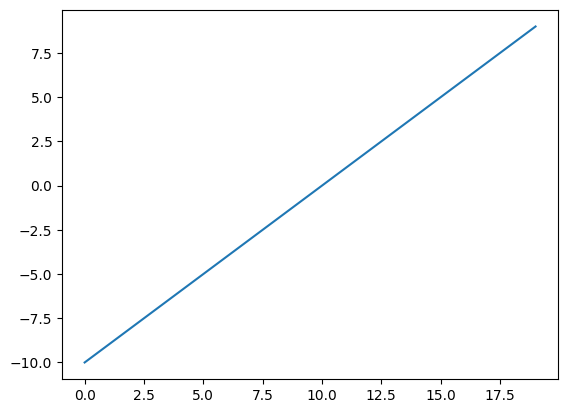

In [295]:
# Visualize the tensor
plt.plot(A)

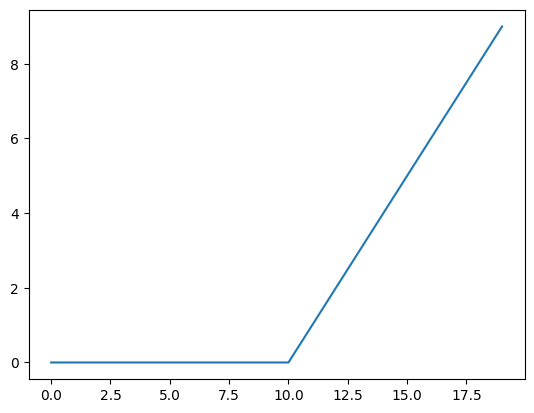

In [297]:
plt.plot(F.relu(A))

In [299]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.max(torch.tensor(0), x)


relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

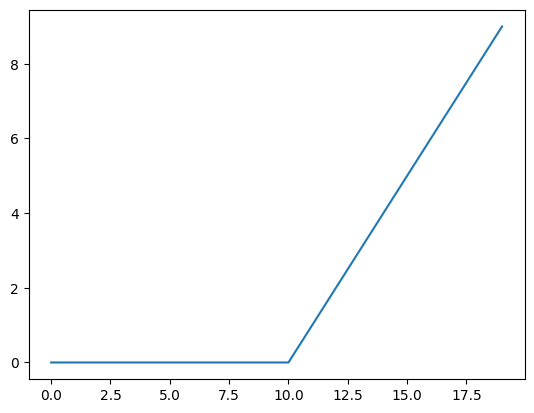

In [300]:
# Plot ReLU activation function
plt.plot(relu(A))

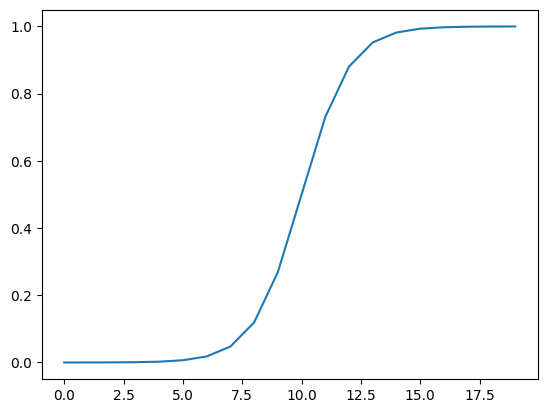

In [301]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))


plt.plot(sigmoid(A))

## Multi-class classification problem


### Create a toy multi-class classification dataset


Text(0.5, 1.0, 'Blobs in 2D')

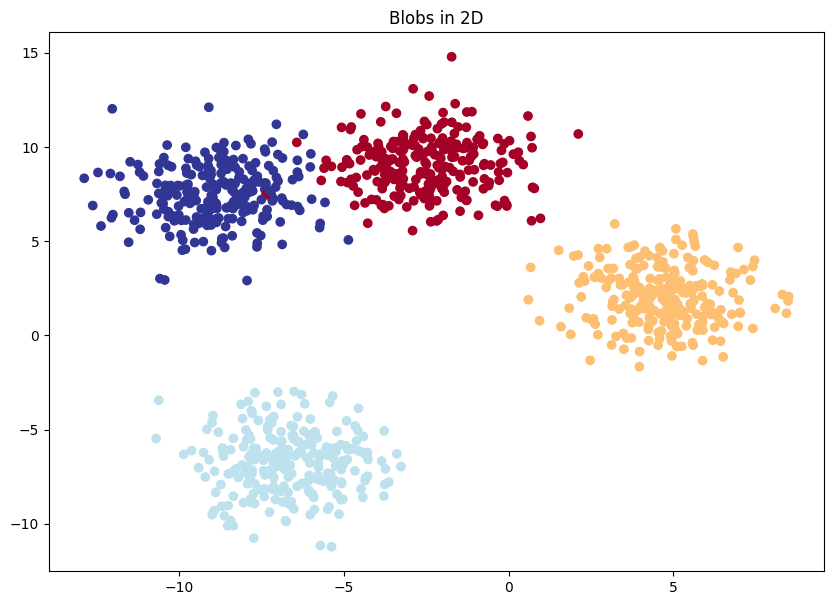

In [303]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(
    n_samples=1000,
    centers=NUM_CLASSES,
    cluster_std=1.5,  # Give the clusters a little shake up
    n_features=NUM_FEATURES,
    random_state=RANDOM_SEED,
)

X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.float32)

X_train_blob, X_test_blob, y_train_blob, y_test_blob = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.title("Blobs in 2D")

### Build a multi-class classification model


In [327]:
class BlobModel(nn.Module):
    def __init__(self, in_features: int, out_features: int, hidden_units: int = 10):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)


model_4 = BlobModel(in_features=NUM_FEATURES, out_features=NUM_CLASSES).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

### Create a loss function and an optimizer for a multi-class classification model


In [328]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_4.parameters(), lr=0.1)

### Ge prediction probabilities for multi-class classification model


In [329]:
# Get some logits from the model
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_test_blob.to(device))
y_logits[:5]

tensor([[ 0.0365,  0.1922, -0.1006, -0.4806],
        [-0.3323, -0.2557, -0.2520, -0.2754],
        [-0.4645, -0.1558, -0.2836, -0.2585],
        [-0.0481,  0.1178, -0.0440, -0.3274],
        [ 0.1002,  0.2445, -0.1777, -0.7642]], device='mps:0')

In [330]:
# Convert logit outputs to prediction probilities
y_pred_probs = F.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[0.2750, 0.3213, 0.2397, 0.1640],
        [0.2369, 0.2557, 0.2567, 0.2507],
        [0.2088, 0.2844, 0.2502, 0.2566],
        [0.2537, 0.2995, 0.2548, 0.1919],
        [0.2999, 0.3465, 0.2272, 0.1264]], device='mps:0')

In [331]:
# Conver prediction probilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5], y_test_blob[:5]

(tensor([1, 2, 1, 1, 1], device='mps:0'),
 tensor([1., 3., 2., 1., 0.], device='mps:0'))

### Create training loop and testing loop for multi-class classification model


In [332]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 100

X_train_blob, y_train_blob = X_train_blob.to(device), y_train_blob.to(device)
X_test_blob, y_test_blob = X_test_blob.to(device), y_test_blob.to(device)

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_train_blob)
    y_preds = F.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train_blob)
    acc = accuracy_fn(y_true=y_train_blob, y_pred=y_preds)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_test_blob)
        test_preds = F.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test_blob)
        test_acc = accuracy_fn(y_true=y_test_blob, y_pred=test_preds)

    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 1.29504, Acc: 38.25% | Test loss: 0.88503, Test acc: 63.50%
Epoch: 10 | Loss: 0.02845, Acc: 99.12% | Test loss: 0.00448, Test acc: 100.00%
Epoch: 20 | Loss: 0.02146, Acc: 99.50% | Test loss: 0.00475, Test acc: 99.50%
Epoch: 30 | Loss: 0.01678, Acc: 99.50% | Test loss: 0.00344, Test acc: 100.00%
Epoch: 40 | Loss: 0.01735, Acc: 99.50% | Test loss: 0.00666, Test acc: 100.00%
Epoch: 50 | Loss: 0.01940, Acc: 99.38% | Test loss: 0.00653, Test acc: 99.50%
Epoch: 60 | Loss: 0.01477, Acc: 99.50% | Test loss: 0.00657, Test acc: 100.00%
Epoch: 70 | Loss: 0.01630, Acc: 99.50% | Test loss: 0.00221, Test acc: 100.00%
Epoch: 80 | Loss: 0.01459, Acc: 99.50% | Test loss: 0.00229, Test acc: 100.00%
Epoch: 90 | Loss: 0.01442, Acc: 99.50% | Test loss: 0.00300, Test acc: 100.00%


### Evaluate predictions with a multi-class classification model

In [338]:
model_4.eval()
with torch.inference_mode():
	y_preds = F.softmax(model_4(X_test_blob), dim=1).argmax(dim=1)
torch.allclose(y_preds.to(dtype=torch.float32), y_test_blob)

True

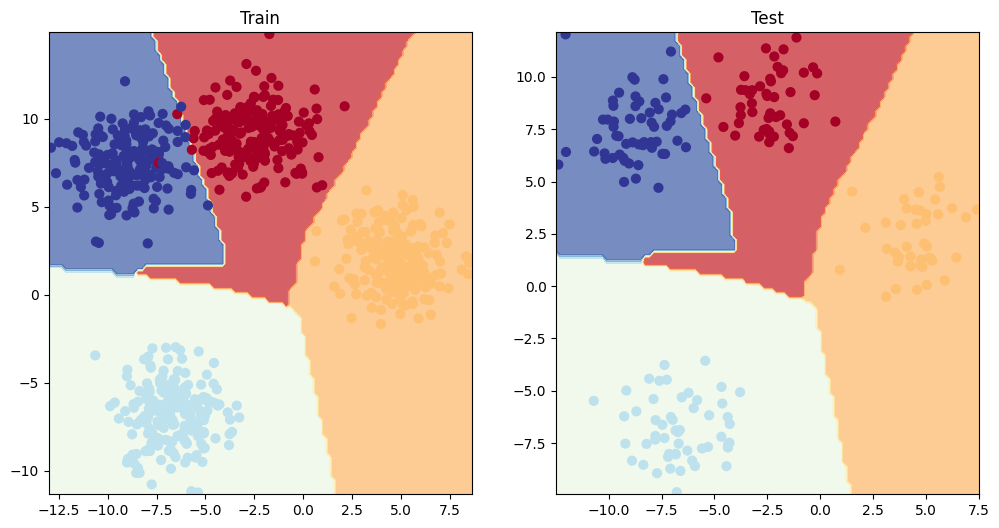

In [339]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_4, X=X_train_blob, y=y_train_blob)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_4, X=X_test_blob, y=y_test_blob)

## Classification metrics to evaluate model

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [340]:
from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_test_blob)

tensor(1., device='mps:0')